# NTSB Modeling XG BOOST

## Notes

1. Unknowns all filled with nan values
2. Rebalancing done as random under sampling and over sampling
3. 4 categoris (consider 3 categories) (consider SMOTE)

## Create data strings

In [1]:
import pandas as pd
import numpy as np
import csv
import re
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

In [2]:
data = pd.read_csv('labeled_clean_ntsb.csv')

C:\Users\htwal\AppData\Local\Temp\ipykernel_25648\421915254.py:1: DtypeWarning: Columns (3,17,18,23,44,45,78,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('labeled_clean_ntsb.csv')


In [3]:
time1 = pd.read_csv('flight_time_pt.csv')
time2 = pd.read_csv('flight_time_pre.csv')

In [4]:
time = pd.concat([time1, time2])
time = time.drop(['Aircraft_Key', 'crew_no'], axis=1)

In [5]:
time['ev_id'] = time['ev_id'].str.lower()

In [6]:
# create a pivot table:
time_pt = pd.pivot_table(time, values='flight_hours', index=['ev_id'], columns=['flight_craft'])

In [7]:
time_pt.shape

(78293, 12)

In [8]:
data = data.fillna(np.nan)
data = data.replace('', np.nan)
data = data.replace('nan', np.nan)
data = data.replace('unk', np.nan)
data = data.replace('unknown', np.nan)

In [9]:
# merge with main data set
data_set = data.merge(time_pt, left_on='aircraft_ev_id', right_on='ev_id')

In [10]:
# Create training dataset:
cols = ['Unnamed: 0', 'aircraft_ev_id', 'far_part', 'damage', 'phase_flt_spec', 'ntsb_no', 
        'ev_year', 'ev_type', 'apt_dist', 'apt_dir', 'ev_highest_injury', 'inj_tot_t', 'secondary_eng_mfgr',
        'crew_inj_level', 'inj_target', 'damage_target', 'hp_or_lbs', 'carb_fuel_injection', 'wx_src_iic', 'wx_obs_fac_id', 'wx_obs_elev', 'wx_obs_dir', 'wx_obs_dist',
        'gust_ind', 'wind_vel_ind', 'crew_category', 'pilot_flying', 'med_certf', 'INC', 'LTA', 'GLDR',
        'REL']
data_set = data_set.drop(cols, axis=1)

In [11]:
data_set = data_set.applymap(lambda x: re.sub(r'\bn\b', 'no', x) if type(x) == str else x)
data_set = data_set.applymap(lambda x: re.sub(r'\by\b', 'yes', x) if type(x) == str else x)

In [12]:
data_set = data_set.applymap(lambda x: x.strip() if type(x) == str else x)

In [13]:
data_set[data_set.select_dtypes(['object']).columns] = data_set.select_dtypes(['object']).astype('category')

In [14]:
data_set[data_set.select_dtypes(['category']).columns] = data_set.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [15]:
cat_cols = data_set.select_dtypes(include='category').columns.tolist()

### Create a rebalanced dataset

In [16]:
target = data_set['target'].astype(int)

In [17]:
target.value_counts()

3    33403
4    11968
2      589
1       92
Name: target, dtype: int64

In [18]:
data_vals = data_set.drop(['target'], axis=1)

In [19]:
# undersample 3
rus = RandomUnderSampler(sampling_strategy={3:11968}, random_state=25)
X_res, y_res = rus.fit_resample(data_vals, target)
print('Resampled dataset shape %s' % Counter(y_res))

# oversample 1, 2
ros = RandomOverSampler(random_state=33)
X_bal, y_bal = ros.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_bal))

Resampled dataset shape Counter({3: 11968, 4: 11968, 2: 589, 1: 92})
Resampled dataset shape Counter({1: 11968, 2: 11968, 3: 11968, 4: 11968})


In [20]:
print(len(X_bal))
print(len(y_bal))

47872
47872


## Model Setup

Training Round 0
-----------------------
Training Score: 91.58
f1 score: 84.78
Accuracy: 84.98
Precision: 84.73
Recall: 84.98
Training Round 1
-----------------------
Training Score: 91.65
f1 score: 84.41
Accuracy: 84.59
Precision: 84.41
Recall: 84.59
Training Round 2
-----------------------
Training Score: 91.78
f1 score: 85.22
Accuracy: 85.4
Precision: 85.16
Recall: 85.4
Training Round 3
-----------------------
Training Score: 91.66
f1 score: 84.7
Accuracy: 84.92
Precision: 84.59
Recall: 84.92
Training Round 4
-----------------------
Training Score: 91.71
f1 score: 84.94
Accuracy: 85.13
Precision: 84.81
Recall: 85.13
Training Round 5
-----------------------
Training Score: 91.57
f1 score: 85.08
Accuracy: 85.27
Precision: 84.98
Recall: 85.27
Training Round 6
-----------------------
Training Score: 91.71
f1 score: 84.81
Accuracy: 85.0
Precision: 84.74
Recall: 85.0
Training Round 7
-----------------------
Training Score: 91.73
f1 score: 85.37
Accuracy: 85.54
Precision: 85.27
Recall: 85.

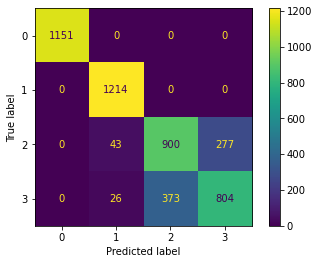

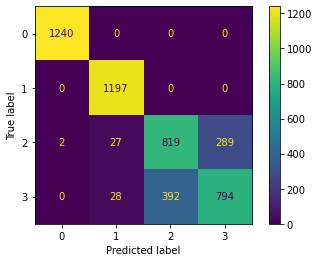

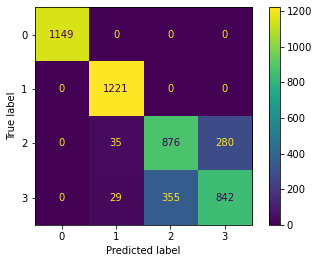

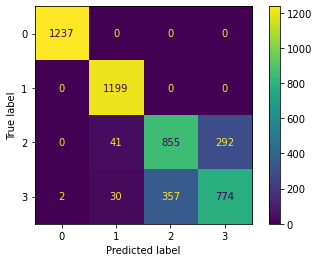

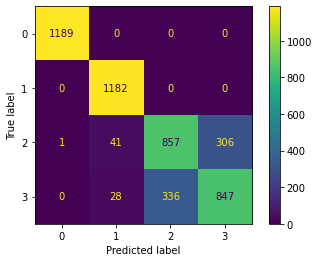

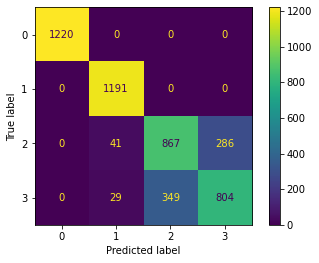

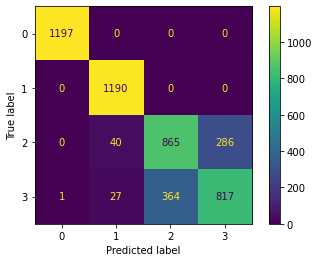

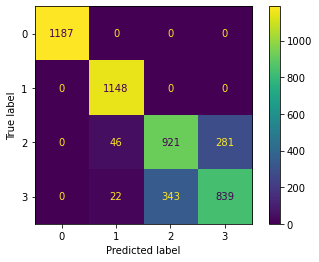

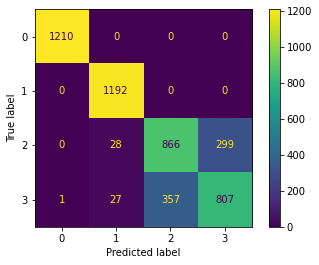

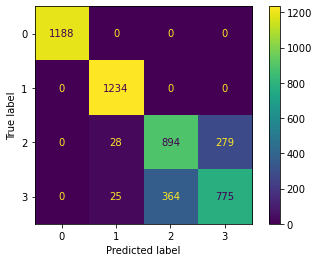

In [24]:
n_folds = 10  # or any other number of your choice
kf = KFold(n_splits=n_folds, shuffle=True, random_state=33)

counter = 0 
for fold, (train_idx, val_idx) in enumerate(kf.split(X_bal, y_bal)):
    X_train, y_train = X_bal.iloc[train_idx], y_bal.iloc[train_idx]
    X_val, y_val = X_bal.iloc[val_idx], y_bal.iloc[val_idx]
    
    model = HistGradientBoostingClassifier(categorical_features=cat_cols)  # or any other HistGradientBoostingClassifier model of your choice
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    y_pred = model.predict(X_val)
    
    f1 = metrics.f1_score(y_val, y_pred, average='weighted')
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred, average='weighted')
    recall = metrics.recall_score(y_val, y_pred, average='weighted')
    
    print(f'Training Round {counter}')
    print('-----------------------')
    print(f'Training Score: {(score*100).round(2)}')
    print(f'f1 score: {(f1*100).round(2)}')
    print(f'Accuracy: {(accuracy*100).round(2)}')
    print(f'Precision: {(precision*100).round(2)}')
    print(f'Recall: {(recall*100).round(2)}')
    cm = metrics.confusion_matrix(y_val, y_pred)
    print(metrics.ConfusionMatrixDisplay(cm).plot())
    counter += 1